# Text Summarization - Support Both English & Chinese Inputs
### www.KudosData.com
#### By: Sam GU Zhan
#### March, 2017

# Imports

In [1]:
# coding=UTF-8
from __future__ import division
import re

# Python2 unicode & float-division support:
# from __future__ import unicode_literals, division

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io

# 中文字符和语言处理库
import jieba

# 机器学习库 sklearn 分类学习模型库
#from sklearn import linear_model
from sklearn.feature_extraction import DictVectorizer # 数据结构变换：把 Dict 转换为 稀疏矩阵
# from sklearn.linear_model import LogisticRegression  # 逻辑回归分类模型
# from sklearn.pipeline import make_pipeline # 封装机器学习模型流程
# from sklearn.metrics import confusion_matrix, roc_curve, auc

# 中文显示设置
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 
mpl.rcParams['font.size'] = 14 # 设置字体大小

np.random.seed(88)

# Define Functions

In [3]:
# Python3
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
def KudosData_word_tokenizer(foo):
    # remove lead & tail spaces firstly:
    foo = foo.strip()
    seg_token = jieba.cut(str(foo), cut_all=True)
    seg_str = str(' '.join(seg_token)).strip()

    return seg_str
# Python2
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
# def KudosData_word_tokenizer(foo):
#     seg_token = jieba.cut(foo, cut_all=True)
#     seg_str = ' '.join(seg_token)
#     return seg_str

In [4]:
# Python3
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
def KudosData_word_count(foo):
    # remove lead & tail spaces firstly:
    foo = foo.strip()
    seg_token = jieba.cut(str(foo), cut_all=True)
    seg_str = str(' '.join(seg_token)).strip()
    seg_count = pd.value_counts(str(seg_str).lower().split(' '))
    seg_count = seg_count.to_dict() 
    seg_count.pop('', None) # remove EMPTY dict key: ''
#     输出 dictionary： { key 词组， value 计数 }
    #     return seg_count.to_dict()
    return seg_count

# Python2
# 中文分词功能小函数， 输出 dictionary： { key 词组， value 计数 }
# def KudosData_word_count(foo):
#     seg_token = jieba.cut(foo, cut_all=True)
#     seg_str = '^'.join(seg_token)
#     seg_count = pd.value_counts(seg_str.lower().split('^'))
#     return seg_count.to_dict()


# Input text

In [5]:
# process Unicode text input
with io.open('input_text.txt','r',encoding='utf8') as f:
    content = f.read()

title = '''
<Dummy Title>
'''

In [6]:
# content

In [7]:
def format_sentence(text):
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\t+', '', text) # remove one or more Tab
    return text

In [8]:
def linebreak_conversion_win_linux(text):
    text = re.sub(r'\r', '', text) # remove one or more Windows-line-break
    text = re.sub(r'\u3000', ' ', text) # convert white space: \u3000    
    return text

In [9]:
def clean_some_whitespace_1(text): # Does not remove normal Space
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\t+', '', text) # remove one or more Tab
    text = re.sub(r'\f+', '', text) # remove one or more special Space
    text = re.sub(r'\v+', '', text) # remove one or more special Space
    text = re.sub(r' +', ' ', text) # merge two or more Spaces to 1 Space
    
    # remove lead & tail spaces:
    text =text.strip()
    
    return text

In [10]:
def clean_some_whitespace_2(text): # Does not remove normal Space
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\n+', ' ', text) # Change one or more \n to a Space, this is to merge sentences within paragraph
    text = re.sub(r' +', ' ', text) # merge two or more Spaces to 1 Space
    text = re.sub(r'(\^\*\#)( +)(\#\*\^)', '^*##*^', text) # remove one or more Spaces between Paragraph-Tags or Sentence-Tags
    
    text = re.sub(r'(\#\*\^S\^\*\#)+', '#*^S^*#', text) # merge two or more sentence-Tags -> 1 Sentence-Tag
    text = re.sub(r'(\#\*\^P\^\*\#)+', '#*^P^*#', text) # merge two or more Paragraph-Tags -> 1 Paragraph-Tag
    
    # remove a Sentence-Tag immediately before a Paragraph-Tag
    text = re.sub(r'(\#\*\^S\^\*\#)( *)(\#\*\^P\^\*\#)', '#*^P^*#', text) 

    # remove lead & tail spaces:
    text =text.strip()
    
    return text

In [11]:
### Define Paragraph-Tag =  
#   #*^P^*#

### Define Sentence-Tag =  
#   #*^S^*#


In [12]:
# add a special tag to end of each paragraph
def tag_paragraph(text):
    text = re.sub(r'((\n ) +)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + two or more Spaces
    text = re.sub(r'((\n\t) +)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + two or more Tabs
    text = re.sub(r'(\n( *)\n)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + zero or more Spaces + \n
    text = re.sub(r'(\#\*\^P\^\*\#)+', '#*^P^*#', text) # merge two or more Paragraph-Tags -> 1 Paragraph-Tag

    return text

In [13]:
# add a special tag to end of each sentence
def tag_sentence(text):
    text = re.sub(r'。+', '。#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'！+', '！#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'\？+', '？#*^S^*#', text) # Tag sentence - Chinese
#     text = re.sub(r'；+', '；#*^S^*#', text) # Tag sentence - Chinese

    # 2017 MAR 24
    text = re.sub(r'(\.)( +)', '.#*^S^*#', text) # Tag sentence - English
    text = re.sub(r'(!)( +)', '!#*^S^*#', text) # Tag sentence - English
    text = re.sub(r'\?( +)', '?#*^S^*#', text) # Tag sentence - English
#     text = re.sub(r'(;)( +)', ';#*^S^*#', text) # Tag sentence - English

    text = re.sub(r'\.\n', '.#*^S^*#', text) # Tag sentence - English
    text = re.sub(r'!\n', '!#*^S^*#', text) # Tag sentence - English
    text = re.sub(r'\?\n', '?#*^S^*#', text) # Tag sentence - English
#     text = re.sub(r';\n', ';#*^S^*#', text) # Tag sentence - English
    
    # remove a Sentence-Tag immediately before an ending quotation
    text = re.sub(r'\#\*\^S\^\*\#’', '’#*^S^*#', text) # Chinese ’
    text = re.sub(r'\#\*\^S\^\*\#”', '”#*^S^*#', text) # Chinese ”
    text = re.sub(r'\#\*\^S\^\*\#\'', '\'#*^S^*#', text) # English '
    text = re.sub(r'\#\*\^S\^\*\#"', '"#*^S^*#', text) # English "
    
    return text

### Start tagging:

In [14]:
content_format = linebreak_conversion_win_linux(content)
content_format

'Golden Age 《黄金时代》\nWang xiaobo 王小波\n \n \none  一  \n \nWhen I was twenty years old, I was "jumping" in Yunnan.   我二十一岁时，正在云南“插队”。\n Chen Ching-yang was twenty-six years old, just when I jumped into the team as a doctor. 陈清扬当时二十六岁，就在我插队的地方当医生。\n I am under the foot of the fourteen teams in the mountains, she fifteen teams in the mountains. 我在山下十四队，她在山上十五队。\n One day she came down from the mountain, and I discussed her not the \'broken shoes\'. 有一天她从山上下来，和我讨论她不是‘破鞋’的问题。\n At that time I did not know her, can only say that little know. 那时我还不大认识她，只能说有一点知道。\n The thing she wants to discuss is this: though all the people say she is a broken shoe, but she thinks she is not. 她要讨论的事是这祥的：虽然所有的人都说她是一个破鞋，但她以为自己不是的。\n Because the broken shoes to steal Han, and she did not laugh Han. 因为破鞋偷汉，而她没有愉过汉。\n Although her husband had lived for one year, she had not stolen. 虽然她丈夫已经住了一年监狱，但她没有偷过汉。\n Before this did not steal Han. 在此之前也未偷过汉。\n So she simply do not understand why people say she is broken shoes

In [15]:
content_format = tag_paragraph(content_format)
content_format

'Golden Age 《黄金时代》\nWang xiaobo 王小波#*^P^*# \none  一  #*^P^*#When I was twenty years old, I was "jumping" in Yunnan.   我二十一岁时，正在云南“插队”。\n Chen Ching-yang was twenty-six years old, just when I jumped into the team as a doctor. 陈清扬当时二十六岁，就在我插队的地方当医生。\n I am under the foot of the fourteen teams in the mountains, she fifteen teams in the mountains. 我在山下十四队，她在山上十五队。\n One day she came down from the mountain, and I discussed her not the \'broken shoes\'. 有一天她从山上下来，和我讨论她不是‘破鞋’的问题。\n At that time I did not know her, can only say that little know. 那时我还不大认识她，只能说有一点知道。\n The thing she wants to discuss is this: though all the people say she is a broken shoe, but she thinks she is not. 她要讨论的事是这祥的：虽然所有的人都说她是一个破鞋，但她以为自己不是的。\n Because the broken shoes to steal Han, and she did not laugh Han. 因为破鞋偷汉，而她没有愉过汉。\n Although her husband had lived for one year, she had not stolen. 虽然她丈夫已经住了一年监狱，但她没有偷过汉。\n Before this did not steal Han. 在此之前也未偷过汉。\n So she simply do not understand why people say she is broken s

In [16]:
print(len(content_format))

10944


In [17]:
content_format = clean_some_whitespace_1(content_format)
content_format

'Golden Age 《黄金时代》\nWang xiaobo 王小波#*^P^*# \none 一 #*^P^*#When I was twenty years old, I was "jumping" in Yunnan. 我二十一岁时，正在云南“插队”。\n Chen Ching-yang was twenty-six years old, just when I jumped into the team as a doctor. 陈清扬当时二十六岁，就在我插队的地方当医生。\n I am under the foot of the fourteen teams in the mountains, she fifteen teams in the mountains. 我在山下十四队，她在山上十五队。\n One day she came down from the mountain, and I discussed her not the \'broken shoes\'. 有一天她从山上下来，和我讨论她不是‘破鞋’的问题。\n At that time I did not know her, can only say that little know. 那时我还不大认识她，只能说有一点知道。\n The thing she wants to discuss is this: though all the people say she is a broken shoe, but she thinks she is not. 她要讨论的事是这祥的：虽然所有的人都说她是一个破鞋，但她以为自己不是的。\n Because the broken shoes to steal Han, and she did not laugh Han. 因为破鞋偷汉，而她没有愉过汉。\n Although her husband had lived for one year, she had not stolen. 虽然她丈夫已经住了一年监狱，但她没有偷过汉。\n Before this did not steal Han. 在此之前也未偷过汉。\n So she simply do not understand why people say she is broken shoes

In [18]:
print(len(content_format))

10917


In [19]:
content_format = tag_sentence(content_format)
content_format

'Golden Age 《黄金时代》\nWang xiaobo 王小波#*^P^*# \none 一 #*^P^*#When I was twenty years old, I was "jumping" in Yunnan.#*^S^*#我二十一岁时，正在云南“插队”。#*^S^*#\n Chen Ching-yang was twenty-six years old, just when I jumped into the team as a doctor.#*^S^*#陈清扬当时二十六岁，就在我插队的地方当医生。#*^S^*#\n I am under the foot of the fourteen teams in the mountains, she fifteen teams in the mountains.#*^S^*#我在山下十四队，她在山上十五队。#*^S^*#\n One day she came down from the mountain, and I discussed her not the \'broken shoes\'.#*^S^*#有一天她从山上下来，和我讨论她不是‘破鞋’的问题。#*^S^*#\n At that time I did not know her, can only say that little know.#*^S^*#那时我还不大认识她，只能说有一点知道。#*^S^*#\n The thing she wants to discuss is this: though all the people say she is a broken shoe, but she thinks she is not.#*^S^*#她要讨论的事是这祥的：虽然所有的人都说她是一个破鞋，但她以为自己不是的。#*^S^*#\n Because the broken shoes to steal Han, and she did not laugh Han.#*^S^*#因为破鞋偷汉，而她没有愉过汉。#*^S^*#\n Although her husband had lived for one year, she had not stolen.#*^S^*#虽然她丈夫已经住了一年监狱，但她没有偷过汉。#*^S^*#\n Before

In [20]:
print(len(content_format))

12029


In [21]:
content_format = clean_some_whitespace_2(content_format)
content_format

'Golden Age 《黄金时代》 Wang xiaobo 王小波#*^P^*# one 一 #*^P^*#When I was twenty years old, I was "jumping" in Yunnan.#*^S^*#我二十一岁时，正在云南“插队”。#*^S^*# Chen Ching-yang was twenty-six years old, just when I jumped into the team as a doctor.#*^S^*#陈清扬当时二十六岁，就在我插队的地方当医生。#*^S^*# I am under the foot of the fourteen teams in the mountains, she fifteen teams in the mountains.#*^S^*#我在山下十四队，她在山上十五队。#*^S^*# One day she came down from the mountain, and I discussed her not the \'broken shoes\'.#*^S^*#有一天她从山上下来，和我讨论她不是‘破鞋’的问题。#*^S^*# At that time I did not know her, can only say that little know.#*^S^*#那时我还不大认识她，只能说有一点知道。#*^S^*# The thing she wants to discuss is this: though all the people say she is a broken shoe, but she thinks she is not.#*^S^*#她要讨论的事是这祥的：虽然所有的人都说她是一个破鞋，但她以为自己不是的。#*^S^*# Because the broken shoes to steal Han, and she did not laugh Han.#*^S^*#因为破鞋偷汉，而她没有愉过汉。#*^S^*# Although her husband had lived for one year, she had not stolen.#*^S^*#虽然她丈夫已经住了一年监狱，但她没有偷过汉。#*^S^*# Before this did not steal

In [22]:
print(len(content_format))

11881



### Transfer tagged text to Pandas Dataframe

In [23]:
# Split a text into paragraphs
def split_article_to_paragraphs(text):
#     text = text.replace("#*^P^*#", "#*^S^*#") # convert Paragraph-Tag        
    return text.split("#*^P^*#")


In [24]:
# Split a paragraph into sentences
def split_paragraph_to_sentences(text):
#     text = text.replace("#*^P^*#", "#*^S^*#") # convert Paragraph-Tag        
    return text.split("#*^S^*#")


In [25]:
# 1st loop Paragraphs list, 2nd loop Sentences list
# create a few new columns, then write into dataframe, together with original Sentence string

# define empty dataframe:
df_article = pd.DataFrame(columns=('sentence', 
                                   'word_count', # sentence word count, including punctuations 
                                   'sentence_id', # unique sentence s/n within an article
                                   'sentence_id_paragraph',  # sentence s/n within a paragraph 
                                   'paragraph_id', 
                                   'class_rank', 
                                   'score_word', # score based on word tf-idf
                                   'score_sentence', # score based on intersection of sentence pairs
                                   'score_word_norm', # Normalized score
                                   'score_sentence_norm', # Normalized score
                                   'score',
                                  ))
df_sentence_id = 0

# split_article_to_paragraphs:
article_paragraphs = split_article_to_paragraphs(content_format)

for i in range(0, len(article_paragraphs)):
    # split_paragraph_to_sentences:
    article_paragraphs_sentences = split_paragraph_to_sentences(article_paragraphs[i].strip())

    for j in range(0, len(article_paragraphs_sentences)):
        if article_paragraphs_sentences[j].strip() != '':
            df_sentence_id = df_sentence_id + 1
            # write to dataframe:
            df_article.loc[len(df_article)] = [article_paragraphs_sentences[j].strip(), 
                                               len(article_paragraphs_sentences[j].strip()), 
                                               df_sentence_id, 
                                               j+1, 
                                               i+1, 
                                               '', 
                                               '', 
                                               '', 
                                               '', 
                                               '', 
                                               '']


In [26]:
# Make sure no empty sentences:
print('Number of empty sentences in dataframe: %d ' % len(df_article[df_article['sentence'] == '']))

Number of empty sentences in dataframe: 0 


In [27]:
df_article

,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score
0,Golden Age 《黄金时代》 Wang xiaobo 王小波,33,1,1,1,,,,,,
1,one 一,5,2,1,2,,,,,,
2,"When I was twenty years old, I was ""jumping"" i...",55,3,1,3,,,,,,
3,我二十一岁时，正在云南“插队”。,16,4,2,3,,,,,,
4,"Chen Ching-yang was twenty-six years old, just...",87,5,3,3,,,,,,
5,陈清扬当时二十六岁，就在我插队的地方当医生。,22,6,4,3,,,,,,
6,I am under the foot of the fourteen teams in t...,95,7,5,3,,,,,,
7,我在山下十四队，她在山上十五队。,16,8,6,3,,,,,,
8,"One day she came down from the mountain, and I...",84,9,7,3,,,,,,
9,有一天她从山上下来，和我讨论她不是‘破鞋’的问题。,25,10,8,3,,,,,,


In [28]:
# assume the 1st sentence as Title of Article

title = df_article['sentence'][0]
print('Title of Article : ', title)

Title of Article :  Golden Age 《黄金时代》 Wang xiaobo 王小波


# Calculate importance score for each sentence

### [Optional Reference] word_tokenizer

In [29]:
# KudosData_word_tokenizer
df_article['sentence_tokenized'] = df_article['sentence'].apply(lambda x: KudosData_word_tokenizer(x))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\TELESC~1\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\TELESC~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.886 seconds.
DEBUG:jieba:Loading model cost 1.886 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


### [Optional Reference] Term Frequency

In [30]:
# KudosData_word_count
df_article['sentence_tf'] = df_article['sentence'].apply(lambda x: KudosData_word_count(x))

### [Optional Reference] TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df_article['sentence_tokenized']

vectorizer = TfidfVectorizer()

# my_stopword_list = ['and','to','the','of', 'in']
#vectorizer = TfidfVectorizer(stop_words=my_stopword_list)

# choice of no nomalization of tfidf output (not recommended)
#vectorizer = TfidfVectorizer(norm=None)

# TF-IDF score
tfidf = vectorizer.fit_transform(corpus)

# IDF score
idf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# TF is in df_article[['sentence_tf']]

In [32]:
### 把TF-iDF数值赋予相对应的词组
tfidf = tfidf.tocsr()

n_docs = tfidf.shape[0]
tfidftables = [{} for _ in range(n_docs)]
terms = vectorizer.get_feature_names()

for i, j in zip(*tfidf.nonzero()):
    tfidftables[i][terms[j]] = tfidf[i, j]

In [33]:
# Document-Term-Matrix's TF-IDF matrix size:
print ('This tfidf matrix is a very large table: [ %d rows/docs X %d columns/words ]' 
       % (tfidf.shape[0], tfidf.shape[1]))
print ('It contains %d eliments: one score per word per document !'
       % (tfidf.shape[0] * tfidf.shape[1]))

This tfidf matrix is a very large table: [ 173 rows/docs X 955 columns/words ]
It contains 165215 eliments: one score per word per document !


In [34]:
# Add tfidf score into dataframe 
df_article['tfidf'] = tfidftables

In [35]:
# df_article[['sentence', 'sentence_tokenized', 'sentence_tf', 'tfidf']]

### Scoring (1)
### Calculate score_word for each sentence, based on sentence word_count tf-idf:

In [36]:
# experiment: use tf-idf and len(sentence_tokenized) to calculate score
# tmp_mean = tmp_sum / len(df_article['sentence_tokenized'][i])

for i in range(0,len(df_article)):
    if len(df_article['tfidf'][i]) == 0:
        df_article['score_word'][i] = 0
    else:
        tmp_sum = 0
        for key, values in df_article['tfidf'][i].items():
            tmp_sum += values
        
        tmp_mean = tmp_sum / len(df_article['sentence_tokenized'][i])
        df_article['score_word'][i] = tmp_mean 


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Scoring (2)
### Calculate score_sentence for each sentence, based on pair-wise sentence comparison/intersection:

In [37]:
# Caculate raw intersection score between pair of two sentences, from df_article['sentence_tokenized']
def sentences_intersection(sent1tokenized, sent2tokenized):
    # www.KudosData.com - Chinese
    # split the sentence into words/tokens
    s1 = set(sent1tokenized.split(" "))
    s2 = set(sent2tokenized.split(" "))

    # If there is not intersection, just return 0
    if (len(s1) + len(s2)) == 0:
        print('# If there is not intersection, just return 0')
        return 0

    # Normalize the result by the average number of words
    return len(s1.intersection(s2)) / ((len(s1) + len(s2)) / 2)


### Below step runs long time... Tuning needed

In [38]:
# Calculate important score of every pair of sentences

n = len(df_article['sentence_tokenized'])
        
# [Sam python 2.7 -> 3.4] values = [[0 for x in xrange(n)] for x in xrange(n)]
df_score_raw_values = [[0 for x in range(n)] for x in range(n)]
for i in range(0, n):
    for j in range(0, n):
        df_score_raw_values[i][j] = sentences_intersection(df_article['sentence_tokenized'][i], 
                                                           df_article['sentence_tokenized'][j])

# The score of a sentence is the sum of all its intersection
sentences_dic = {}

for i in range(0, n):
    df_score = 0
    for j in range(0, n):
        if i == j:
            continue
        df_score += df_score_raw_values[i][j]
    df_article['score_sentence'][i] = df_score


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Visualize Data (Internal use,  not for production)

In [39]:
df_article

,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score,sentence_tokenized,sentence_tf,tfidf
0,Golden Age 《黄金时代》 Wang xiaobo 王小波,33,1,1,1,,0.0666667,9.39332,,,,Golden Age 黄金 黄金时代 时代 Wang xiaobo 王小波 小波,"{'wang': 1, '王小波': 1, '时代': 1, '小波': 1, '黄金': ...","{'wang': 0.333333333333, '黄金时代': 0.33333333333..."
1,one 一,5,2,1,2,,0.166667,13.5035,,,,one 一,"{'one': 1, '一': 1}",{'one': 1.0}
2,"When I was twenty years old, I was ""jumping"" i...",55,3,1,3,,0.0507267,13.7356,,,,When I was twenty years old I was jumping i...,"{'jumping': 1, 'yunnan': 1, 'years': 1, 'i': 2...","{'yunnan': 0.364095706313, 'old': 0.3179237058..."
3,我二十一岁时，正在云南“插队”。,16,4,2,3,,0.078869,12.9058,,,,我 二十 二十一 二十一岁 十一 十一岁 一岁 时 正在 云南 插队,"{'二十一': 1, '一岁': 1, '我': 1, '十一岁': 1, '时': 1, ...","{'二十一岁': 0.340609310474, '二十一': 0.340609310474..."
4,"Chen Ching-yang was twenty-six years old, just...",87,5,3,3,,0.0458388,14.8645,,,,Chen Ching yang was twenty six years old just...,"{'twenty': 1, 'i': 1, 'a': 1, 'when': 1, 'was'...","{'twenty': 0.259772583624, 'when': 0.247627291..."
5,陈清扬当时二十六岁，就在我插队的地方当医生。,22,6,4,3,,0.0658594,15.1256,,,,陈 清扬 当时 二十 二十六 二十六岁 十六 十六岁 六岁 就 在 我 插队 的 地方 ...,"{'陈': 1, '我': 1, '二十六': 1, '二十六岁': 1, '插队': 1,...","{'插队': 0.295035861112, '二十六岁': 0.3186754411, '..."
6,I am under the foot of the fourteen teams in t...,95,7,5,3,,0.0326362,17.2873,,,,I am under the foot of the fourteen teams in t...,"{'of': 1, 'i': 1, 'the': 4, 'am': 1, 'in': 2, ...","{'am': 0.193536469567, 'of': 0.138891330994, '..."
7,我在山下十四队，她在山上十五队。,16,8,6,3,,0.0904582,16.871,,,,我 在 山下 十四 四队 她 在 山上 十五 五队,"{'我': 1, '五队': 1, '她': 1, '四队': 1, '十五': 1, '山...","{'四队': 0.43222889382, '十五': 0.400165834699, '山..."
8,"One day she came down from the mountain, and I...",84,9,7,3,,0.0442745,21.0142,,,,One day she came down from the mountain and I...,"{'from': 1, 'i': 1, 'her': 1, 'down': 1, 'and'...","{'from': 0.306254850477, 'her': 0.213410066814..."
9,有一天她从山上下来，和我讨论她不是‘破鞋’的问题。,25,10,8,3,,0.0648028,19.0684,,,,有 一天 她 从 山上 上下 下来 和 我 讨论 她 不是 破鞋 的 问题,"{'我': 1, '下来': 1, '她': 2, '讨论': 1, '破鞋': 1, '从...","{'下来': 0.372018450987, '讨论': 0.372018450987, '..."


In [40]:
# This is to check if there is any sentence with zero valid/real word
len(df_article[df_article['word_count'] == None])

0

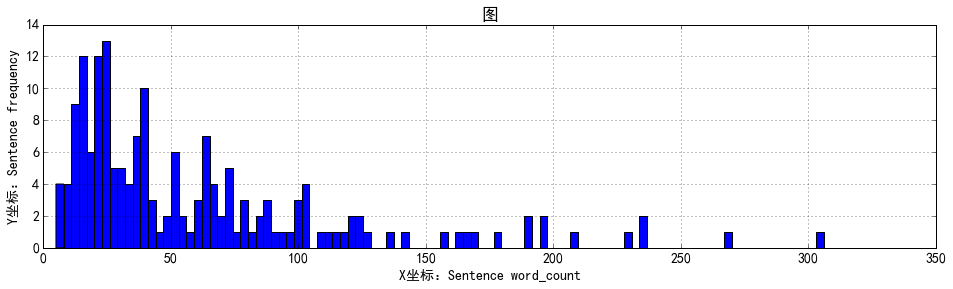

In [41]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：Sentence word_count')  
plt.ylabel(u'Y坐标：Sentence frequency')  
# df_article['word_count'].value_counts().sort_values(ascending=False).plot(kind='bar', color='green')
df_article['word_count'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


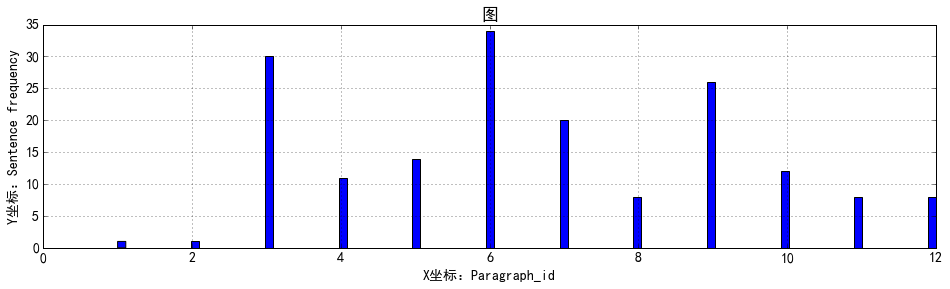

In [42]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：Paragraph_id')  
plt.ylabel(u'Y坐标：Sentence frequency')  
df_article['paragraph_id'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


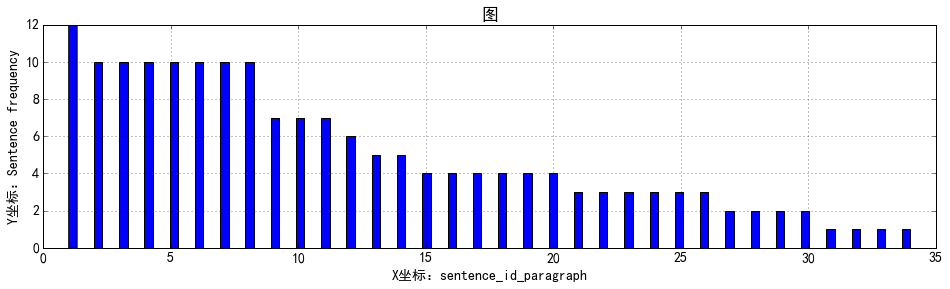

In [43]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：sentence_id_paragraph')  
plt.ylabel(u'Y坐标：Sentence frequency')  
df_article['sentence_id_paragraph'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


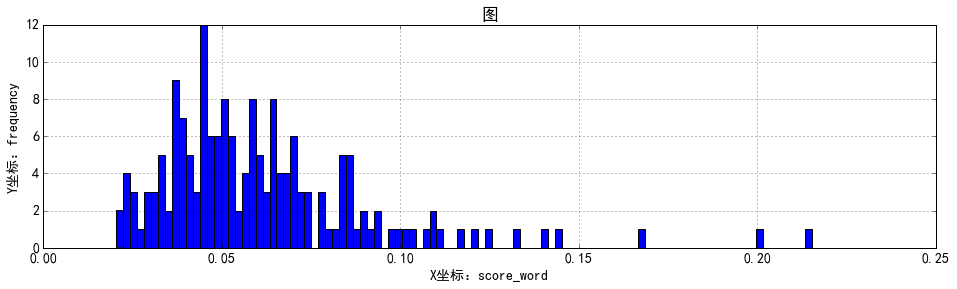

In [44]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：score_word')  
plt.ylabel(u'Y坐标：frequency')  
df_article['score_word'].hist(bins = 100)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0,0.5)
#plt.ylim(0,0.5)
# plt.gca().invert_yaxis()
plt.show()


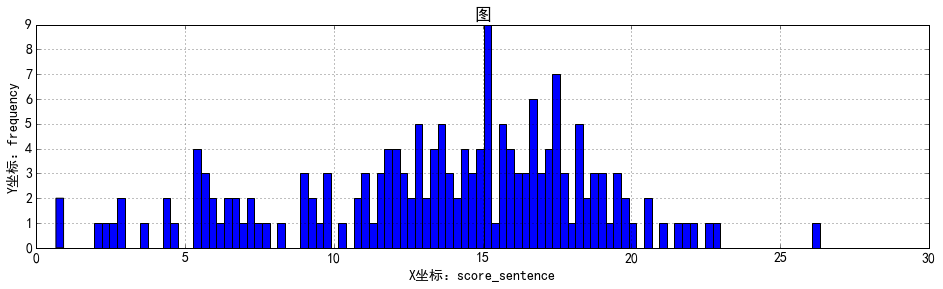

In [45]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：score_sentence')  
plt.ylabel(u'Y坐标：frequency')  
df_article['score_sentence'].hist(bins = 100)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0,0.5)
#plt.ylim(0,0.5)
# plt.gca().invert_yaxis()
plt.show()


In [46]:
# df_article[(df_article['score_word'] > 0.15) & (df_article['score_word'] < 0.25)]
# df_article[(df_article['score_word'] > 0.2)].sort_values(by=['score_sentence', 'score_word'], ascending=[False, False,])
# df_article[(df_article['score_sentence'] > 250)].sort_values(by=['score_word', 'score_sentence'], ascending=[False, False,])


### Score Normalization

In [47]:
# log(score_word)
df_article['score_word_log'] = np.log(df_article['score_word'].astype('float64') + 
                                      df_article[df_article['score_word'] >0 ]['score_word'].min()/2)


In [48]:
# Normalize score_word_log - Zero mean, unit variance

# df_article['score_word_norm'] = (df_article['score_word'] - df_article['score_word'].mean()) / df_article['score_word'].std()
df_article['score_word_norm'] = (df_article['score_word_log'] - df_article['score_word_log'].mean()) / df_article['score_word_log'].std()

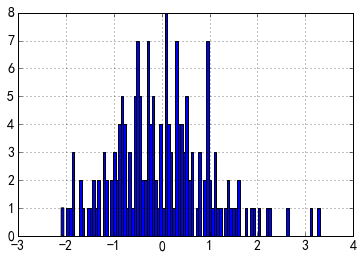

In [49]:
df_article['score_word_norm'].hist(bins=100)

In [50]:
# Normalize score_sentence - Zero mean, unit variance

df_article['score_sentence_norm'] = (df_article['score_sentence'] - df_article['score_sentence'].mean()) / df_article['score_sentence'].std()

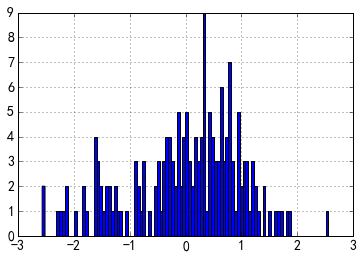

In [51]:
df_article['score_sentence_norm'].hist(bins=100)

### Generate class_rank

In [52]:
# Score integration
# df_article['score'] = (df_article['score_sentence_norm'] + df_article['score_word_norm']) / 2

# Sam Gu: 23 Mar 2017 - Experiment found that the score_word, which is based on tf-idf, doesn't seem to work well.
#                       score_word     tends to favor short sentences
#                       score_sentence tends to favor long  sentences
#                       Hence, here we use score_sentence only for final scoring.

# df_article['score'] = (df_article['score_word'] + df_article['score_sentence'] ) / 2
df_article['score'] = df_article['score_sentence']

In [53]:
# Min-Max normalization:
df_article['score'] = (df_article['score'] - df_article['score'].min()) / (df_article['score'].max() -df_article['score'].min())

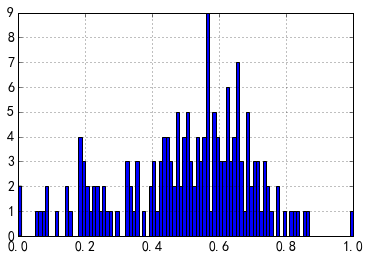

In [54]:
df_article['score'].hist(bins=100)

In [55]:
# sort firstly
df_article = df_article.sort_values(by=['paragraph_id', 'score'], ascending=[True, False]).reset_index(drop=True)

### Below step runs long time... Tuning needed

In [56]:
# Generate Class_Rank

current_class_rank = 0
current_paragraph_id = 0

for i in range(0, len(df_article)):
    if df_article['paragraph_id'][i] != current_paragraph_id: # change of Paragraph, thus reset class_rank
        current_class_rank = 1
        current_paragraph_id = df_article['paragraph_id'][i]
    else:
        current_class_rank = current_class_rank + 1
        
    df_article['class_rank'][i] = current_class_rank


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [57]:
# sort Dataframe to 'result lookup mode'
df_article = df_article.sort_values(by=['class_rank', 'score', 'paragraph_id', 'sentence_id'], 
                                    ascending=[True, False, True, True]).reset_index(drop=True)

In [58]:
df_article[['sentence',
           'paragraph_id',
           'sentence_id_paragraph',
           'class_rank',
           'score',
           'sentence_tokenized'
          ]]

,sentence,paragraph_id,sentence_id_paragraph,class_rank,score,sentence_tokenized
0,Chen Qingyang find me to prove that she is not...,4,1,1,1,Chen Qingyang find me to prove that she is not...
1,I think so: if I want to prove that she is not...,8,1,1,0.868936,I think so if I want to prove that she is not...
2,"Because the broken shoes to steal Han, and she...",3,13,1,0.858232,Because the broken shoes to steal Han and she...
3,"The problem is not good to break shoes, but ra...",5,7,1,0.810088,The problem is not good to break shoes but ra...
4,Those people are not actually to see the docto...,7,9,1,0.777683,Those people are not actually to see the docto...
5,"If you do not want to be broken shoes, it is n...",6,17,1,0.756263,If you do not want to be broken shoes it is n...
6,"I said, to prove that we are innocent, only to...",10,11,1,0.719984,I said to prove that we are innocent only to...
7,"So she decided, sooner or later to hit me a sl...",12,5,1,0.711176,So she decided sooner or later to hit me a sl...
8,Not to mention the captain if it can provoke a...,9,13,1,0.702,Not to mention the captain if it can provoke a...
9,one 一,2,1,1,0.500446,one 一


In [59]:
# df_article[(df_article['score'] == 0) | (df_article['score'] == 1)]

# Extract results based on user parameters:
* Max number of words
* % of original number of words
* Max lines of sentences


In [60]:
# Make a dataframe copy
# Currently, the two dataframes are exactly the same.
df_article_internal = pd.DataFrame.copy(df_article)

In [61]:
total_words_original_article = df_article['sentence'].map(len).sum()
total_words_internal_article = df_article_internal['sentence'].map(len).sum()
# total_words_article_summary  = df_article_final['sentence'].map(len).sum()

# print('total_words_original_article : ', total_words_original_article)
# print('total_words_internal_article : ', total_words_internal_article)
# print('total_words_article_summary  : ', total_words_article_summary)


In [62]:
# Sam Gu: experiment shows no major improvement to use code in this block:

'''

# Heuristic cleaning:
# 1.Remove sentences, which has only one valid word. 
# 2.Remove paragraph, which has only single sentence.

# 1.
df_article_internal = df_article_internal[df_article_internal['sentence_tokenized'].map(len) > 1]
print('*** www.KudosData.com *** Removed number of sentences, which has only one valid word : %d'
      % (len(df_article) - len(df_article_internal)))

# 2.
df_article_internal_paragraph = df_article_internal['paragraph_id'].value_counts().to_frame(name = 'sentence_count')
df_article_internal_paragraph = df_article_internal_paragraph[df_article_internal_paragraph['sentence_count'] > 1]
valid_paragraph_id = df_article_internal_paragraph.index.tolist()
df_article_internal = df_article_internal[df_article_internal['paragraph_id'].isin(valid_paragraph_id)] 
print('*** www.KudosData.com *** Removed number of sentences in total : %d' % (len(df_article) - len(df_article_internal)))

# sort Dataframe to 'result lookup mode'
df_article_internal = df_article_internal.sort_values(by=['class_rank', 'score', 'paragraph_id', 'sentence_id'], 
                                    ascending=[True, False, True, True]).reset_index(drop=True)
# Above sort a must sort !!! for below processing:
# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

'''

"\n\n# Heuristic cleaning:\n# 1.Remove sentences, which has only one valid word. \n# 2.Remove paragraph, which has only single sentence.\n\n# 1.\ndf_article_internal = df_article_internal[df_article_internal['sentence_tokenized'].map(len) > 1]\nprint('*** www.KudosData.com *** Removed number of sentences, which has only one valid word : %d'\n      % (len(df_article) - len(df_article_internal)))\n\n# 2.\ndf_article_internal_paragraph = df_article_internal['paragraph_id'].value_counts().to_frame(name = 'sentence_count')\ndf_article_internal_paragraph = df_article_internal_paragraph[df_article_internal_paragraph['sentence_count'] > 1]\nvalid_paragraph_id = df_article_internal_paragraph.index.tolist()\ndf_article_internal = df_article_internal[df_article_internal['paragraph_id'].isin(valid_paragraph_id)] \nprint('*** www.KudosData.com *** Removed number of sentences in total : %d' % (len(df_article) - len(df_article_internal)))\n\n# sort Dataframe to 'result lookup mode'\ndf_article_intern

### Accept user parameters:

In [63]:
# valid range: >= 0
parm_max_word = 200

# valid range: >= 0
parm_max_sentence = 10

# valid range: [0, 100%]
parm_max_percent = 0.01

### Validation of user parameters:

In [64]:
if (isinstance(parm_max_word, int) | isinstance(parm_max_word, float)):
    if parm_max_word >= 0:
        print('!1! valid input parm_max_word : ', parm_max_word)
    else:
        print('!2! Invalid input parm_max_word : ', parm_max_word)    
else:
    print('!3! Invalid input parm_max_word : ', parm_max_word)

if (isinstance(parm_max_sentence, int) | isinstance(parm_max_sentence, float)):
    if parm_max_sentence >= 0:
        print('!1! valid input parm_max_sentence : ', parm_max_sentence)
    else:
        print('!2! Invalid input parm_max_sentence : ', parm_max_sentence)    
else:
    print('!3! Invalid input parm_max_sentence : ', parm_max_sentence)

if (isinstance(parm_max_percent, int) | isinstance(parm_max_percent, float)):
    if parm_max_percent >= 0:
        print('!1! valid input parm_max_percent : ', parm_max_percent)
    else:
        print('!2! Invalid input parm_max_percent : ', parm_max_percent)    
else:
    print('!3! Invalid input parm_max_percent : ', parm_max_percent)


!1! valid input parm_max_word :  200
!1! valid input parm_max_sentence :  10
!1! valid input parm_max_percent :  0.01


In [65]:
# cut by parm_max_percent

# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

sum_current_word = 0
cut_index = len(df_article_internal['sentence'])

# print('Start loop...')
for s in range(0, len(df_article_internal['sentence'])):
#     print('s : %d' % s)
    if sum_current_word / total_words_original_article <= parm_max_percent:
        sum_current_word += len(df_article_internal['sentence'][s])
    else:
#         stop, return index number
        cut_index = s - 1
        sum_current_word -= len(df_article_internal['sentence'][s-1])

#         print('To break')
        break

# print('End loop')
sum_current_percent = sum_current_word / total_words_original_article
print('---------- cut by parm_max_percent :')
print('sum_current_word  / total_words_original_article:', sum_current_percent)
print('cut_index : ', cut_index)

---------- cut by parm_max_percent :
sum_current_word  / total_words_original_article: 0.009636277751535192
cut_index :  1


In [66]:
# cut by parm_max_word

# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

sum_current_word = 0
cut_index = len(df_article_internal['sentence'])

# print('Start loop...')
for s in range(0, len(df_article_internal['sentence'])):
#     print('s : %d' % s)
    if sum_current_word <= parm_max_word:
        sum_current_word += len(df_article_internal['sentence'][s])
    else:
#         stop, return index number
        cut_index = s - 1
        sum_current_word -= len(df_article_internal['sentence'][s-1])
#         print('To break')
        break

# print('End loop')
print('---------- cut by parm_max_word :')
print('sum_current_word :', sum_current_word)
print('cut_index : ', cut_index)

---------- cut by parm_max_word :
sum_current_word : 102
cut_index :  1


In [67]:
# cut by parm_max_sentence

cut_index = parm_max_sentence

print('---------- cut by parm_max_sentence :')
print('cut_index : ', cut_index)

---------- cut by parm_max_sentence :
cut_index :  10


In [68]:
# Extract top number of sentences as summary, based on: cut_index
df_article_final = df_article_internal[0:cut_index]

In [69]:
# sort by original sentence order 
df_article_final = df_article_final.sort_values(by=['sentence_id'], ascending=[True])
df_article_final[['sentence_id', 'sentence', 'score', 'class_rank', 'paragraph_id', 'sentence_id_paragraph']]

,sentence_id,sentence,score,class_rank,paragraph_id,sentence_id_paragraph
9,2,one 一,0.500446,1,2,1
2,15,"Because the broken shoes to steal Han, and she...",0.858232,1,3,13
0,33,Chen Qingyang find me to prove that she is not...,1,1,4,1
3,50,"The problem is not good to break shoes, but ra...",0.810088,1,5,7
5,74,"If you do not want to be broken shoes, it is n...",0.756263,1,6,17
4,100,Those people are not actually to see the docto...,0.777683,1,7,9
1,112,I think so: if I want to prove that she is not...,0.868936,1,8,1
8,132,Not to mention the captain if it can provoke a...,0.702,1,9,13
6,156,"I said, to prove that we are innocent, only to...",0.719984,1,10,11
7,170,"So she decided, sooner or later to hit me a sl...",0.711176,1,12,5


In [70]:
# total_words_original_article = df_article['sentence'].map(len).sum()
# total_words_internal_article = df_article_internal['sentence'].map(len).sum()
total_words_article_summary  = df_article_final['sentence'].map(len).sum()

print('total_words_original_article : ', total_words_original_article)
print('total_words_internal_article : ', total_words_internal_article)
print('total_words_article_summary  : ', total_words_article_summary)


total_words_original_article :  10585
total_words_internal_article :  10585
total_words_article_summary  :  921


# Output results to a file

In [71]:
# print('\n'.join(list(df_article_final['sentence'])))

In [72]:

with io.open('output_topic_summary.txt','w',encoding='utf8') as f:
#     f.write("Original Length : %s" % total_words_original_article)
    f.write("No. Paragraphs  : %d" % df_article_internal['paragraph_id'].max())
    f.write("\n")
    f.write("Original Length : %s" % total_words_internal_article)
    f.write("\n")
    f.write("Summary  Length : %s" % total_words_article_summary)
    f.write("\n")
#     f.write("Summary  Ratio  : %s %%" % (100 * (sum_current_word / total_words_original_article)))
    f.write("Summary  Ratio  : %.2f %%" % (100 * (total_words_article_summary / total_words_internal_article)))
    f.write("\n")
    f.write("\n")
    f.write("Title of Article: %s" % title)
    f.write("\n")
    f.write("\n")
    f.write('\n'.join(list(df_article_final['sentence'])))
    f.close()
    

In [73]:
# This is to check if there is sentence with very few valid/real word, should have very low score.

# df_article[df_article['word_count'] == None]
df_article[['sentence', 'sentence_tokenized' , 'tfidf', 'score']][df_article['word_count'] <= 5]

,sentence,sentence_tokenized,tfidf,score
9,one 一,one 一,{'one': 1.0},0.500446
